In [99]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM,Dense, Dropout,Embedding, SimpleRNN,GRU
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [100]:
df=pd.read_csv("D:/Vedant/NLP/food_review.csv")

In [101]:
df.head()

,Unnamed: 0,Text,Score
0,0,I bought these from a large chain pet store. a...,1
1,1,"This soup is incredibly good! But honestly, I...",5
2,2,Our family loves these tasty and healthy sesam...,5
3,3,The local auto shop offers this free to it cus...,4
4,4,I brought 2 bottles. One I carry in my pocket...,5


In [102]:
df=df.drop(columns=["Unnamed: 0"])

In [103]:
df.head()

,Text,Score
0,I bought these from a large chain pet store. a...,1
1,"This soup is incredibly good! But honestly, I...",5
2,Our family loves these tasty and healthy sesam...,5
3,The local auto shop offers this free to it cus...,4
4,I brought 2 bottles. One I carry in my pocket...,5


In [104]:
df['Score'].value_counts()

4    8117
5    8106
3    8103
2    8095
1    8079
Name: Score, dtype: int64

In [105]:
df.isna().sum()

Text     0
Score    0
dtype: int64

In [106]:
df.isnull().sum()

Text     0
Score    0
dtype: int64

In [107]:
df.dtypes

Text     object
Score     int64
dtype: object

In [108]:
df['Score']=df['Score'].map(lambda x:'positive' if x>3 else 'negative')

In [109]:
le = LabelEncoder()

In [110]:
df['Score']=le.fit_transform(df['Score'])

In [111]:
df['Score']

0        0
1        1
2        1
3        1
4        1
        ..
40495    1
40496    0
40497    1
40498    0
40499    1
Name: Score, Length: 40500, dtype: int32

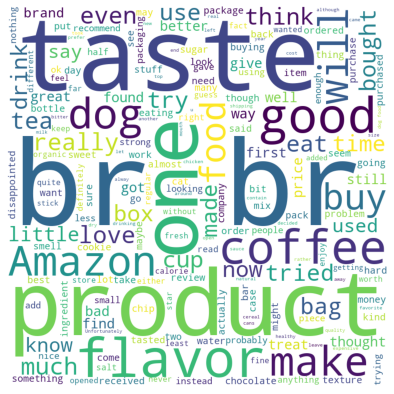

In [112]:
wc = WordCloud(width = 800, height = 800, 
              background_color ='white',  
              min_font_size = 10)

wc.generate(''.join(df[df["Score"]==0]["Text"]))
  
plt.figure(figsize = (7,7)) 
plt.imshow(wc) 
plt.axis("off") 
plt.show()

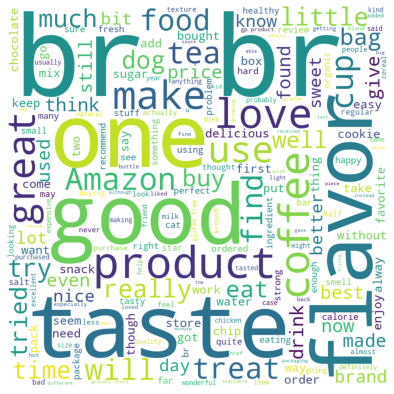

In [113]:
wc = WordCloud(width = 800, height = 800, 
              background_color ='white',  
              min_font_size = 10)

wc.generate(''.join(df[df["Score"]==1]["Text"]))
  
plt.figure(figsize = (7,7)) 
plt.imshow(wc) 
plt.axis("off") 
plt.show()

In [114]:
def clean_text(text):
    stop=stopwords.words('english')
    punc=list(punctuation)
    bad_token=stop+punc
    lemma=WordNetLemmatizer()
    tokens = word_tokenize(text)
    word_token=[t for t in tokens if t.isalpha()]
    clean_token=[lemma.lemmatize(t.lower()) for t in word_token if t not in bad_token]
    return " ".join(clean_token)

In [115]:
df["Text"]=df["Text"].apply(clean_text)

In [116]:
x=df['Text']
y=df['Score']

In [117]:
sent_len=[]
for sent in df['Text']:
    sent_len.append(len(word_tokenize(sent)))
df['sent_len']=sent_len

In [118]:
np.quantile(sent_len,0.95)

131.0

In [119]:
max_len=47

In [120]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=1)

In [121]:
tok=Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(xtrain)

In [122]:
vocab_len=len(tok.index_word)

In [123]:
vocab_len

28208

In [124]:
sequences_train=tok.texts_to_sequences(xtrain)

In [125]:
sequences_matrix_train=sequence.pad_sequences(sequences_train,maxlen=max_len)

In [126]:
sequences_matrix_train

array([[   0,    0,    0, ...,  682,  254,   62],
       [   0,    0,    0, ...,  110,  561,  885],
       [   0,    0,    0, ..., 1516,  491,   10],
       ...,
       [   0,    0,    0, ...,   23, 1263, 1027],
       [  49, 1805, 1274, ...,   84,  862,  564],
       [2878,    9,   21, ...,  249,  491,  166]])

In [127]:
model = Sequential()
model.add(Embedding(vocab_len+1,500,input_length=max_len,mask_zero=True))
model.add(GRU(32,activation='tanh'))
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [140]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 47, 500)           14104500  
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                51264     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 14,156,853
Trainable params: 14,156,853
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.compile(optimizer="adam", loss="binary_crossentropy",metrics=['binary_accuracy'])

In [153]:
trained_model=model.fit(sequences_matrix_train,ytrain,batch_size=50, epochs=50,validation_split=0.2)

Epoch 1/50
519/519 [==============================] - 142s 251ms/step - loss: 0.0021 - binary_accuracy: 0.9995 - val_loss: 0.0158 - val_binary_accuracy: 0.9955
Epoch 2/50
519/519 [==============================] - 124s 240ms/step - loss: 4.0527e-04 - binary_accuracy: 0.9998 - val_loss: 0.0307 - val_binary_accuracy: 0.9920
Epoch 3/50
519/519 [==============================] - 124s 238ms/step - loss: 0.0012 - binary_accuracy: 0.9995 - val_loss: 0.0365 - val_binary_accuracy: 0.9898
Epoch 4/50
519/519 [==============================] - 125s 241ms/step - loss: 0.0060 - binary_accuracy: 0.9981 - val_loss: 0.0455 - val_binary_accuracy: 0.9872
Epoch 5/50
519/519 [==============================] - 122s 235ms/step - loss: 0.0027 - binary_accuracy: 0.9992 - val_loss: 0.0529 - val_binary_accuracy: 0.9844
Epoch 6/50
519/519 [==============================] - 123s 237ms/step - loss: 0.0021 - binary_accuracy: 0.9996 - val_loss: 0.0556 - val_binary_accuracy: 0.9843
Epoch 7/50
519/519 [================

In [154]:
sequences_matrix_test = sequence.pad_sequences(tok.texts_to_sequences(xtest),maxlen=max_len)

In [155]:
ypred=model.predict(sequences_matrix_test)

In [156]:
ypred = np.where(ypred>=0.5,1,0)

In [157]:
from sklearn.metrics import classification_report

In [158]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      4871
           1       0.75      0.74      0.74      3229

    accuracy                           0.80      8100
   macro avg       0.79      0.79      0.79      8100
weighted avg       0.80      0.80      0.80      8100

